# Estimation of FRET efficiency for emission for known dyes

Based on Medintz & Hildebrandt, 2014, pages 23-31.

FRET efficiency, $E$, is
$$
E = \frac{R_0^6}{R_0^6 + r_{DA}^6}
$$
where
$r_{DA}$ is the distance between donor and acceptor
and 
$R_0$ is the Förster distance.
This is also expressed as
$$
E = \frac{k_T}{k_T + 1/\tau_D}
$$
where
$k_T$ is the rate of energy transfer
and $t_D$ is the lifetime of the donor excited state in the absence of acceptor.
The formula for $k_T$ is
$$
k_T = \frac{1}{\tau_D} \left( \frac{R_0^6}{r_{DA}^6} \right)
$$

The Förster distance $R_0^6$ is a key quantity to compute,
and is given as
$$
R_0^6 = \frac{9 (\ln 10) \kappa^2 \Phi_D J }{128\pi^5 n^4 N_A}
$$
where $\kappa^2$ is the orientation factor,
$\Phi_D$ is the quantum yield of the donor fluorescence in the absence of acceptor,
$J$ is the overlap integral,
$\pi = 3.14159...$,
$n$ is the index of refraction of the medium,
and $N_A$ is the Avogadro number $6.0221415 \times 10^{23}$ per mol.

The overlap integral $J$, is computed differently depending on whether the spectra are given in terms of wavelength, wave number, or frequency. For wavelength,
$$
J^\lambda = J = \int f_D(\lambda) \epsilon_A(\lambda) \lambda^4 \mathrm{d} \lambda
$$
where $f_D(\lambda)$ is the peak-normalized fluorescence spectrum of the donor,
$\epsilon_A(\lambda)$ is the molar extinction coefficient (a.k.a. molar absorptivity) of the acceptor (usually in units of $\mathrm{M}^{-1} \mathrm{cm}^{-1}$), and $\lambda$ is the wavelength (usually in nm).

The molar absorptivity $\epsilon_A(\lambda)$ can be computed from
$$
\epsilon_A(\lambda) = f_A(\lambda) \epsilon_0 \Phi_A
$$


The overlap can be computed via the sum

$$
J = \frac{\sum_i f_D(\lambda_i) \epsilon_A(\lambda_i) \lambda_i^4}{\sum_j f_D(\lambda_j)}
$$

In [188]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [189]:
def FRET_efficiency(kappa2, Phi_D, J, n, r_DA):
    R6_0 = forster_distance(kappa2, Phi_D, J, n)
    E = R6_0 / (R6_0 + r_DA**6)
    return E

def forster_distance(kappa2, Phi_D, J, n):
    N_A = 6.0221415e23 # Avogadro number, per mol
    numerator = 9*math.log(10)*kappa2*Phi_D*J
    denominator = 128*(math.pi**5)*(n**4)*N_A
    R_0 = (numerator/denominator)**(1./6.)
    return R_0

kappa2 = 2./3 # orientation factor for dipole interaction
# "The orientation factor takes on a value of κ² = 2/3 for a dynamic and
# isotropic distribution of donor and acceptor orientations"
# "Varies between 0 and 4."

n = 1.33 # index of refraction
# "All refractive index values in the literature are in the 1.33 - 1.6 range.
# The values 1.34 and 1.6 are the ones used most frequently."

r_DA = 2e-9 # 2 nm
# FRET happens in the near field, that is, roughly in the 1-10 nm range."

Phi_D = 0.9
# Quantum efficiency of donor.
# "varies between 0 and 1"

Phi_A = 0.9
# Quantum efficiency of acceptor.

molar_attenuation_coefficient = 45e3 #  M^-1 cm^-1

### ATTO_390_emission_nm, ATTO_390_emission_intensity = np.loadtxt("ATTO_390_emission.csv", delimiter=",", unpack=True, skiprows=1)
plt.clf()
plt.scatter(ATTO_390_emission_nm, ATTO_390_emission_intensity)
plt.xlabel("Photon wavelength (nm)")
plt.ylabel("Peak-normalized emission intensity");

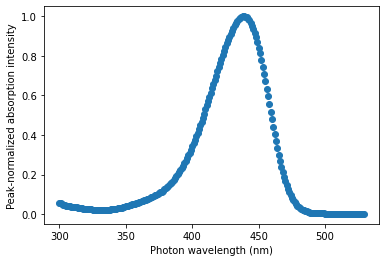

In [190]:
ATTO_425_absorption_nm, ATTO_425_absorption_intensity = np.loadtxt("ATTO_425_absorption.csv", delimiter=",", unpack=True, skiprows=1)
plt.clf()
plt.scatter(ATTO_425_absorption_nm, ATTO_425_absorption_intensity)
plt.xlabel("Photon wavelength (nm)")
plt.ylabel("Peak-normalized absorption intensity");

Now let's see what they look like overlaid.

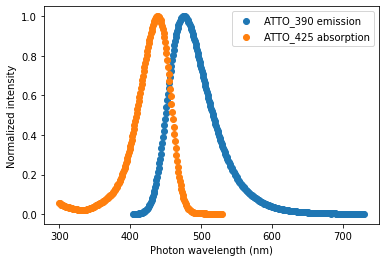

In [191]:
plt.clf()
plt.scatter(ATTO_390_emission_nm, ATTO_390_emission_intensity, label="ATTO_390 emission")
plt.scatter(ATTO_425_absorption_nm, ATTO_425_absorption_intensity, label="ATTO_425 absorption")
plt.xlabel("Photon wavelength (nm)")
plt.legend();
plt.ylabel("Normalized intensity");

In [203]:
# Get a uniformly-spaced lambda range.
lambda_min = max(ATTO_390_emission_nm.min(),ATTO_425_absorption_nm.min())
lambda_max = min(ATTO_390_emission_nm.max(),ATTO_425_absorption_nm.max())
lambda_step = ATTO_390_emission_nm[1]-ATTO_390_emission_nm[0]
n_steps = int((lambda_max - lambda_min)/lambda_step)
lambda_range = np.linspace(lambda_min, lambda_max, n_steps)

def correspond(template, search_in):
    # Find the order of the closest corresponding values.
    order = []
    for val in template:
        order.append(np.abs(val - search_in).argmin())
    return order

ATTO_390_lambda_order = correspond(lambda_range, ATTO_390_emission_nm)
ATTO_390_intensity_new = ATTO_390_emission_intensity[ATTO_390_lambda_order]

ATTO_425_lambda_order = correspond(lambda_range, ATTO_425_absorption_nm)
ATTO_425_intensity_new = ATTO_425_absorption_intensity[ATTO_425_lambda_order]
ATTO_425_molar_absorption = molar_attenuation_coefficient*ATTO_425_intensity_new

def overlap_OLI(lambdas, donor_fluorescence, acceptor_extinction):
    assert len(lambdas) == len(donor_fluorescence) == len(acceptor_extinction)
    # Peak-normalize donor fluorescence.
    f_D_norm = donor_fluorescence/donor_fluorescence.max()
    J_raw = np.zeros(len(lambdas))
    for i, (wavelength_nm, f_D, eps_A) in enumerate(zip(lambdas, f_D_norm, acceptor_extinction)):
        # eps_A has units of 1/(M cm)
        # OLI is 10^14 M^-1 cm^-1 nm^4
        J_raw[i] = 1e14*f_D*eps_A_m2 * (wavelength_nm**4)
    # J_raw has units of m^6/mol
    J = J_raw / f_D_norm.sum()
    return J

def overlap_SI_base(lambdas, donor_fluorescence, acceptor_extinction):
    assert len(lambdas) == len(donor_fluorescence) == len(acceptor_extinction)
    # Peak-normalize donor fluorescence.
    f_D_norm = donor_fluorescence/donor_fluorescence.max()
    J_raw = np.zeros(len(lambdas))
    for i, (wavelength_nm, f_D, eps_A) in enumerate(zip(lambdas, f_D_norm, acceptor_extinction)):
        wavelength_m = wavelength_nm*1e-9
        # eps_A has units of 1/(M cm) = 0.1 m^2/mol
        eps_A_m2 = 0.1*eps_A
        J_raw[i] = f_D*eps_A_m2 * (wavelength_m**4)
    # J_raw has units of m^6/mol
    J = J_raw / f_D_norm.sum()
    return J

def overlap_fpbase(lambdas, donor_fluorescence, acceptor_extinction):
    assert len(lambdas) == len(donor_fluorescence) == len(acceptor_extinction)
    # Peak-normalize donor fluorescence.
    f_D_norm = donor_fluorescence/donor_fluorescence.max()
    J_raw = np.zeros(len(lambdas))
    for i, (wavelength_nm, f_D, eps_A) in enumerate(zip(lambdas, f_D_norm, acceptor_extinction)):
        wavelength_cm = wavelength_nm*1e-7
        # eps_A has units of 1/(M cm)
        eps_A_m2 = eps_A
        J_raw[i] = f_D*eps_A_m2 * (wavelength_cm**4)
    # J_raw has units of cm^4 / M cm
    J = J_raw / f_D_norm.sum()
    return J
    
J_lambda = overlap(lambda_range, ATTO_390_intensity_new, ATTO_425_molar_absorption)
J = J_lambda.sum()
print("{:.4e} m^6/mol".format(J))
J_lambda_2 = overlap_fpbase(lambda_range, ATTO_390_intensity_new, ATTO_425_molar_absorption)
J_2 = J_lambda_2.sum()
print("{:.4e} 1e15 M^-1 cm^-1 nm^4".format(J_2*1e15/100))

3.9678e-23 m^6/mol
3.9678e-01 1e15 M^-1 cm^-1 nm^4


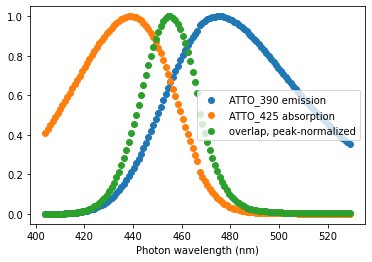

In [193]:
plt.clf()
plt.scatter(lambda_range, ATTO_390_intensity_new, label="ATTO_390 emission")
plt.scatter(lambda_range, ATTO_425_intensity_new, label="ATTO_425 absorption")
plt.scatter(lambda_range, J_lambda/J_lambda.max(), label="overlap, peak-normalized")
plt.legend()
plt.xlabel("Photon wavelength (nm)");

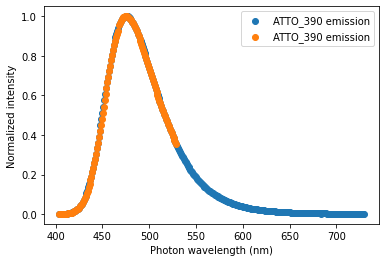

In [194]:
plt.clf()
plt.scatter(ATTO_390_emission_nm, ATTO_390_emission_intensity, label="ATTO_390 emission")
plt.scatter(lambda_range, ATTO_390_intensity_new, label="ATTO_390 emission")
plt.xlabel("Photon wavelength (nm)")
plt.legend();
plt.ylabel("Normalized intensity");

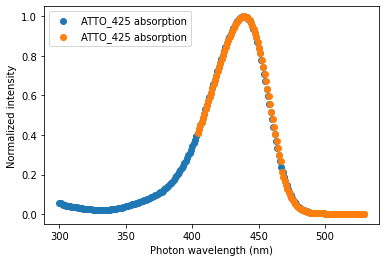

In [195]:
plt.clf()
plt.scatter(ATTO_425_absorption_nm, ATTO_425_absorption_intensity, label="ATTO_425 absorption")
plt.scatter(lambda_range, ATTO_425_intensity_new, label="ATTO_425 absorption")
plt.xlabel("Photon wavelength (nm)")
plt.legend();
plt.ylabel("Normalized intensity");

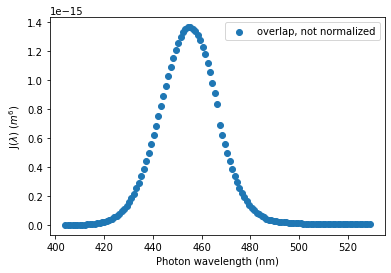

In [196]:
plt.clf()
plt.scatter(lambda_range, J_lambda, label="overlap, not normalized")
plt.legend()
plt.xlabel("Photon wavelength (nm)");
plt.ylabel("$\mathrm{J}(\lambda)$ ($m^6$)");

In [202]:
J_sum = J_lambda.sum()
print(J_sum)
J_OLI = J_sum*1e37
print("{:.3f}×10¹⁵ M⁻¹ cm⁻¹ nm⁴".format(round(J_OLI,3)))

3.967799533658422e-14
396779953365842164449280.000×10¹⁵ M⁻¹ cm⁻¹ nm⁴


In [198]:
J_sum = 3.4e-14
R0_m = forster_distance(kappa2, Phi_D, J_sum, 1.33)
R0_nm = R0_m*1e9
print("{} nm".format(R0_nm))

133.76071620331717 nm


In [184]:
E_total = FRET_efficiency(kappa2, Phi_D, J_sum, n, r_DA)
print(E_total)
E_total = FRET_efficiency(kappa2, Phi_D, J_sum, 1.34, r_DA)
print(E_total)
E_total = FRET_efficiency(kappa2, Phi_D, J_sum, 1.6, r_DA)
print(E_total)

1.0
1.0
1.0
